In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
from pandas.core.indexes.api import InvalidIndexError
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import cv2
import os
import requests
import torch
import argparse
import torchvision
from numpy import expand_dims
from tensorflow.keras.utils import load_img
from keras.models import load_model
from tensorflow.keras.utils import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from torchvision import transforms
#import pickle
#import torch.nn as nn
from torchvision.models import detection
import torchvision.models as models
import torchvision.transforms as transforms
#from torch.autograd import Variable
#from sklearn.metrics import jaccard_similarity_score
from scipy import spatial
#from sklearn.decomposition import PCA as RandomizedPCA
from PIL import Image
import glob
#pd.set_option('display.max_columns', None)
from google.colab.patches import cv2_imshow

In [ ]:
root_path = 'gdrive/My Drive/coco_minitrain_25k/' 

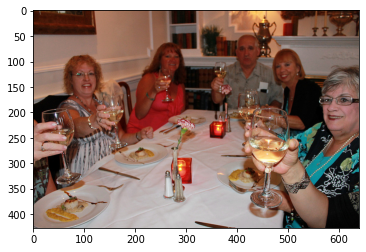

In [ ]:
#Displaying a single image from the folder that contains the images of Class Person
image = plt.imread('/content/gdrive/MyDrive/coco_minitrain_25k /images/images_person/000000104747.jpg')
plt.imshow(image)


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**OBJECT DETECTION USING THE YOLOV3 MODEL**

**Performing object detection using two models namely YOLOv3 and Faster RCNN. The feature extraction and the similarity search is done on the basis of the Faster RCNN model.**

1/1 [==============================] - 4s 4s/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 90.61519503593445
person 99.02355074882507
person 99.6520459651947
person 96.60124182701111
person 99.48447942733765


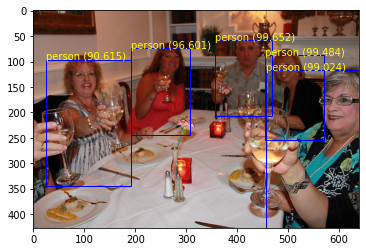

In [ ]:
# Performing Object Detection bu using YOLOV3 model

import numpy as np
from numpy import expand_dims
from tensorflow.keras.utils import load_img
from keras.models import load_model
from tensorflow.keras.utils import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle
 
class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1
 
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
 
		return self.label
 
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
 
		return self.score
 
def _sigmoid(x):
	return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# The first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w 
			y = (row + y) / grid_h 
			w = anchors[2 * b + 0] * np.exp(w) / net_w 
			h = anchors[2 * b + 1] * np.exp(h) / net_h 
			# Class Probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
 

def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3


def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0
 
# Loading an image
filename="/content/gdrive/MyDrive/coco_minitrain_25k /images/images_person/000000104747.jpg"

def load_image_pixels(filename, shape):
	image = load_img(filename)
  #newsize=(800,800)
  #image=image.resize(newsize)
	width, height = image.size
	image = load_img(filename, target_size=shape)
	image = img_to_array(image)
	image = image.astype('float32')
	image /= 255.0
	image = expand_dims(image, 0)
	return image, width, height
 
# The results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	for box in boxes:
		for i in range(len(labels)):
			# Checking if the threshold value for the label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
	return v_boxes, v_labels, v_scores
 
# Drawing the bounding boxes around the objects detected
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	data = pyplot.imread(filename)
	pyplot.imshow(data)
	ax = pyplot.gca()
	# Plotting each bounding box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		width, height = x2 - x1, y2 - y1
		rect = Rectangle((x1, y1), width, height, fill=False, color='blue')
		ax.add_patch(rect)
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='yellow')
	pyplot.show()
 
# Loading the yolov3 model
model = load_model('/content/gdrive/MyDrive/coco_minitrain_25k /images/yolo.h5')
input_w, input_h = 416,416
photo_filename = '/content/gdrive/MyDrive/coco_minitrain_25k /images/images_person/000000104747.jpg'
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# Making prediction
yhat = model.predict(image)
print([a.shape for a in yhat])
# Defining the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# Defining the probability threshold for the detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

# Suppressing the  non-maximal boxes
do_nms(boxes, 0.5)

# Defining the labels to be detected in an image
labels = ["person"]

v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])

#Plotting the bounding box, mentioning the label and the score of the detected object
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

**LOADING A PRETRAINED FASTER RCNN MODEL TO PERFORM OBJECT DETECTION AND EXTRACTING THE BOUNDING BOXES**

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)
model.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and will be removed in 0.15, please use 'weights_backbone' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will

  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
url = 'https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/'
html = requests.get(url).content
df_data= pd.read_html(html)

cls = df_data[0][['ID','Object (2017 Rel.)']]
colors = np.random.uniform(0, 255, size=(len(cls), 3))

In [ ]:
img = cv2.imread("/content/gdrive/My Drive/coco_minitrain_25k /images/images_person/000000104747.jpg")
img = cv2.resize(img,(400,400))
copy_img = img.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img.transpose((2, 0, 1))
img = np.expand_dims(img, axis=0)
img = img / 255.0
img= torch.FloatTensor(img)
img_detect = model(img)[0]

img_detect

{'boxes': tensor([[260.3636, 180.6947, 316.6709, 371.0757],
         [286.2606,  72.3421, 355.2090, 225.1614],
         [109.5842,  58.3929, 199.3368, 249.4389],
         [217.9256,  44.2751, 303.2933, 189.2298],
         [305.7690, 103.2758, 400.0000, 393.6987],
         [ 11.0592, 179.5854,  57.5044, 322.8810],
         [ 82.7028, 148.8340, 111.7303, 253.3809],
         [ 12.4377, 167.7687, 350.0149, 393.5929],
         [222.2103,  95.9693, 237.7692, 133.2494],
         [ 16.4112,  81.4948, 113.9392, 207.9333],
         [253.0263, 150.8167, 279.5703, 233.4896],
         [103.3970, 129.0563, 122.7930, 203.5478],
         [205.3184,  23.9941, 233.9900,  83.9996],
         [ 81.0100, 285.2726, 129.6974, 312.1604],
         [220.1968,  97.5260, 238.7845, 171.4715],
         [187.7587,  42.3426, 195.0481,  71.3883],
         [  9.0765,  81.6254, 134.9935, 277.6748],
         [207.5678,  42.4798, 227.5338,  83.8102],
         [175.8293,  43.6830, 187.1798,  71.1221],
         [151.3108, 10

**DISPLAYING AN IMAGE WITH BOUNDING BOX USING A FASTER RCNN PRETRAINED MODEL**

person: 99.31%


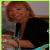

person: 99.16%


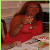

person: 99.07%


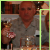

person: 98.83%


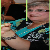

person: 90.71%


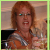

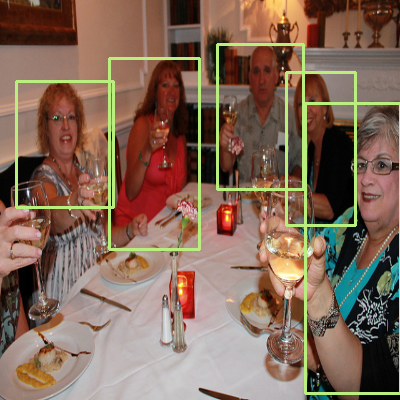

In [ ]:
for j in range(0, len(img_detect["boxes"])):
	confid = img_detect["scores"][j]
	if confid >.90 and int(img_detect["labels"][j])==1:
		idx = int(img_detect["labels"][j])
		box = img_detect["boxes"][j].detach().cpu().numpy()
		(sX, sY, lX, lY) = box.astype("int")

		label = "{}: {:.2f}%".format(list(cls[cls.ID==idx]['Object (2017 Rel.)'].values)[0], confid * 100)
		print(label)
		cv2.rectangle(copy_img, (sX, sY), (lX, lY),colors[idx], 2)
		cv2_imshow(cv2.resize(copy_img[sY:lY,sX:lX],(50,50)))
cv2_imshow(copy_img)

**CALCULATING IOU VALUE FOR AN IMAGE**

IoU is:  0.7059057624960203


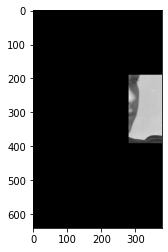

In [ ]:
img = cv2.imread("/content/gdrive/MyDrive/coco_minitrain_25k /images/images_person/000000021895.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Creating a bounding box for an image
first_bb_points = [[250, 210], [440, 210], [440, 390], [250, 390]]
stencil = np.zeros(img.shape).astype(img.dtype)
contours = [np.array(first_bb_points)]
color = [255, 255, 255]
cv2.fillPoly(stencil, contours, color)
result1 = cv2.bitwise_and(img, stencil)
result1 = cv2.cvtColor(result1, cv2.COLOR_BGR2RGB)
plt.imshow(result1)

# Second bounding box
second_bb_points = [[280, 190], [438, 190], [438, 390], [280, 390]]
stencil = np.zeros(img.shape).astype(img.dtype)
contours = [np.array(second_bb_points)]
color = [255, 255, 255]
cv2.fillPoly(stencil, contours, color)
result2 = cv2.bitwise_and(img, stencil)
result2 = cv2.cvtColor(result2, cv2.COLOR_BGR2RGB)
plt.imshow(result2)

# IoU calculation
intersection = np.logical_and(result1, result2)
union = np.logical_or(result1, result2)
iou_score = np.sum(intersection) / np.sum(union)
print('IoU is: ', iou_score)

In [ ]:
img_path = '/content/gdrive/MyDrive/coco_minitrain_25k /images/images_person'
list_person = glob.glob(os.path.join(img_path, "*.jpg"))
df_person = pd.DataFrame(columns = ['boxes','labels','scores','Image_name','object_feature_tensor'])


In [ ]:
p=0
for i in list_person[:200]:
  img = cv2.imread(i)
  img = cv2.resize(img,(300,300))
  copy_img = img.copy()
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img.transpose((2, 0, 1))
  img = np.expand_dims(img, axis=0)
  img = img / 255.0
  img = torch.FloatTensor(img)
  img_detect = model(img)[0]
  for keys in img_detect:
    img_detect[keys] = img_detect[keys].tolist()
  t =  pd.DataFrame.from_dict(img_detect)
  t['Image_name'] = i.split("/")[-1]
  t = t[(t.labels==1) & (t.scores>0.90)]

  df_person = df_person.append(t)
  p = p+1
  if p%100==0:
    print(p)
  

100
200


In [ ]:
#df_person.head()
#final_df.iloc[0]['Image_name']

In [ ]:
p=0
ext_features = []

for index,row in df_person.iterrows():
  img = cv2.imread(img_path+"/"+row['Image_name'])

  box = torch.Tensor(row["boxes"]).detach().cpu().numpy()
  (sX, sY, lX, lY) = box.astype("int")
  person_detect = img[sY:lY,sX:lX]
  person_detect = cv2.resize(person_detect,(100,100))

  person_detect = cv2.cvtColor(person_detect, cv2.COLOR_BGR2RGB)
  person_detect= person_detect.transpose((2, 0, 1))
  person_detect = np.expand_dims(person_detect, axis=0)
  person_detect = person_detect / 255.0
  person_detect = torch.FloatTensor(person_detect)
  
  image, _= model.transform(person_detect, None)
  features = model.backbone(image.tensors)['pool']
  ext_features.append(features.detach().cpu().numpy()[0])
  p = p+1
  if p%100==0:
    print(p)
df_person['object_feature_tensor'] = ext_features

100
200
300
400


In [ ]:
df_person.head(20)

,boxes,labels,scores,Image_name,object_feature_tensor
0,"[100.7398452758789, 79.63508605957031, 169.533...",1,0.998791,000000542160.jpg,"[[[0.24095413, -0.010448603, -0.20650484, -0.4..."
1,"[156.89111328125, 67.85984802246094, 216.45614...",1,0.997613,000000542160.jpg,"[[[0.3017579, 0.14763214, -0.09032594, -0.2764..."
0,"[60.33863830566406, 51.1615104675293, 144.7962...",1,0.999536,000000542260.jpg,"[[[0.26885507, 0.11737903, 0.07570734, 0.06440..."
2,"[167.39083862304688, 117.72058868408203, 192.2...",1,0.998018,000000542260.jpg,"[[[0.27273637, 0.18258235, 0.15158413, 0.09642..."
3,"[254.39669799804688, 119.1002197265625, 274.59...",1,0.995723,000000542260.jpg,"[[[0.2962215, 0.21590297, 0.22268447, 0.267198..."
4,"[157.54129028320312, 117.18836975097656, 172.6...",1,0.989222,000000542260.jpg,"[[[0.25567108, 0.22624795, 0.21963684, 0.14504..."
5,"[22.64716911315918, 115.3060302734375, 45.9203...",1,0.988986,000000542260.jpg,"[[[0.2804906, 0.24319372, 0.22152676, 0.142101..."
6,"[251.35821533203125, 121.0564956665039, 263.77...",1,0.923542,000000542260.jpg,"[[[0.37756002, 0.33343348, -0.14240515, -0.402..."
7,"[36.166015625, 121.91869354248047, 51.17100524...",1,0.911371,000000542260.jpg,"[[[0.27789158, 0.2002584, 0.22222117, 0.148042..."
0,"[166.28662109375, 155.44064331054688, 258.4162...",1,0.999490,000000541643.jpg,"[[[0.28722715, -0.14010337, -0.32491133, -0.14..."


**EXECUTING SIMILARITY SEARCH** 

In [19]:
def calculate_similarity(v1, v2):
 return 1 - spatial.distance.cosine(v1, v2)

query_imagel = [345]
for i in query_imagel:
  t_f = []
  t_df = df_person.copy()
  feat_tesn = torch.FloatTensor(df_person['object_feature_tensor'].iloc[i].flatten())
  for index,row in df_person.iterrows():
    t_f.append(calculate_similarity(feat_tesn,torch.FloatTensor(row['object_feature_tensor'].flatten())))
  df_person['similarity'] = t_f
  #temp_df.sort_values(by = 'similarity', )

df_person.sort_values(by = 'similarity').tail(10)

,boxes,labels,scores,Image_name,object_feature_tensor,similarity
6,"[92.73272705078125, 260.539794921875, 110.0059...",1,0.978550,000000540636.jpg,"[[[0.29499716, 0.21754882, 0.13367122, 0.10641...",0.740922
5,"[49.510162353515625, 182.8935546875, 77.659904...",1,0.914365,000000540569.jpg,"[[[0.31204754, 0.2513754, 0.13329196, 0.113401...",0.743719
1,"[44.980735778808594, 211.6626434326172, 63.746...",1,0.989266,000000539718.jpg,"[[[0.29222903, 0.20526704, 0.08560782, 0.08091...",0.744238
1,"[147.86611938476562, 156.06588745117188, 179.1...",1,0.990367,000000540569.jpg,"[[[0.3085641, 0.21457915, 0.12684058, 0.117091...",0.746757
5,"[190.72445678710938, 146.599609375, 206.604248...",1,0.965307,000000543084.jpg,"[[[0.26579502, 0.18216105, 0.008364971, -0.021...",0.747270
2,"[0.5971312522888184, 166.08078002929688, 28.14...",1,0.949965,000000540569.jpg,"[[[0.31567606, 0.23370895, 0.10515692, 0.11232...",0.747806
0,"[98.4638900756836, 72.88906860351562, 198.1764...",1,0.999671,000000545088.jpg,"[[[0.34462637, 0.29792276, 0.1553613, 0.105522...",0.760982
4,"[277.30718994140625, 159.56915283203125, 290.3...",1,0.987351,000000545920.jpg,"[[[0.26714283, 0.1383501, -0.020036943, -0.164...",0.764280
3,"[217.5285186767578, 165.93333435058594, 238.43...",1,0.987547,000000545920.jpg,"[[[0.28694004, 0.19384573, 0.015970534, -0.086...",0.765152
4,"[48.29283905029297, 0.0, 67.22736358642578, 8....",1,0.963220,000000545334.jpg,"[[[0.24995354, 0.17218901, 0.21727155, 0.22911...",1.000000


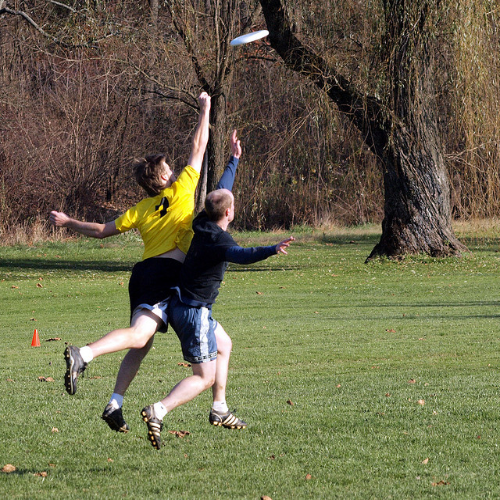

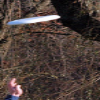

In [25]:
im_path = img_path+"/"+df_person.iloc[15]['Image_name']
img = cv2.imread(im_path)
img_copy = img.copy()
img = cv2.resize(img,(500,500))
cv2_imshow(img)
box = torch.Tensor(df_person.iloc[11]["boxes"]).detach().cpu().numpy()
(sX, sY, lX, lY) = box.astype("int")
person_detect = img[sY:lY,sX:lX]
person_detect = cv2.resize(person_detect,(100,100))
cv2_imshow(person_detect)

In [26]:
calculate_similarity(torch.FloatTensor(df_person['object_feature_tensor'].iloc[0].flatten()),torch.FloatTensor(df_person['object_feature_tensor'].iloc[19].flatten()))

0.6895768046379089

In [27]:
torch.nn.CosineSimilarity(dim=0)(torch.FloatTensor(df_person['object_feature_tensor'].iloc[0]),torch.FloatTensor(df_person['object_feature_tensor'].iloc[14]))

tensor([[ 0.9987,  0.9955,  0.9919,  0.9901,  0.9966,  0.9912,  0.9862,  0.9836,
          0.9819,  0.9758,  0.9467,  0.9438,  0.9764],
        [ 0.9983,  0.9912,  0.9588,  0.9384,  0.9354,  0.9641,  0.9190,  0.9018,
          0.8996,  0.8807,  0.9128,  0.9246,  0.9700],
        [ 0.9969,  0.9634,  0.9242,  0.8358,  0.4868,  0.3182,  0.4339,  0.6854,
          0.7598,  0.6724,  0.8285,  0.8831,  0.9515],
        [ 0.9946,  0.9365,  0.8631,  0.7135,  0.2976, -0.0861,  0.0737,  0.1700,
          0.2376,  0.2207,  0.7114,  0.8326,  0.9507],
        [ 0.9798,  0.8600,  0.6460,  0.3105, -0.3377, -0.3968, -0.2133, -0.1666,
         -0.2661, -0.1757,  0.6570,  0.8186,  0.9537],
        [ 0.9605,  0.7798,  0.6106,  0.4785, -0.1850, -0.1931,  0.1063,  0.2058,
         -0.0057, -0.1079,  0.4312,  0.7589,  0.9395],
        [ 0.9455,  0.7054,  0.4188,  0.1638, -0.1182, -0.1617, -0.0941, -0.0690,
          0.2773,  0.4843,  0.4336,  0.6104,  0.9110],
        [ 0.9581,  0.7795,  0.4826,  0.1354,  0.